In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
import numpy as np, pandas as pd

import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")


%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.pyplot import NullFormatter
import matplotlib
from matplotlib.colors import LogNorm
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}
matplotlib.rc('font', **font)

import seaborn as sns
rc={'font.size': 16, 'axes.labelsize': 16, 'legend.fontsize': 12,
    'axes.titlesize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12}
sns.set(font="serif",style="white",rc=rc)

# Testing distribution function

In [3]:
folder = '/home/andy/Documents/Research/SF/SFdata/Galaxia_data/'
iso_folder = '/home/andy/Documents/Research/SF/SFdata/'

In [4]:
survey = pd.read_csv(folder + '/Galaxia_sf_survey.csv')
survey['Colour'] = survey.Japp-survey.Kapp

pointings = pd.read_csv(folder + '/Galaxia_sf_fieldinfo.csv')
pointings = pointings[['fieldID', 'glon', 'glat', 'halfangle','Magmin', 'Magmax', 'Colmin', 'Colmax']]
pointings.rename({'glon':'phi', 'glat':'theta'})

def get_photo(field):
    
    file_path = folder + '/photometric/'+str(field)+'.csv'
    field_data = pd.read_csv(file_path, usecols=['Japp', 'Happ', 'Kapp'])
    
    field_data['Colour'] = field_data.Japp - field_data.Kapp
    field_data = np.array(field_data[['Happ', 'Colour']])
    
    return field_data

In [6]:
X = get_photo(3.0)

# Fit

In [21]:
sys.path.append('/home/andy/Documents/Research/SF/GitRepo/seestar/')
import SelectionGrid, IsochroneScaling, StatisticalModels, SFInstanceClasses

from sklearn import mixture
from sklearn.cluster import KMeans

import scipy

In [45]:
# Simple GMM
i = 10
gmm = mixture.BayesianGaussianMixture(n_components=i, n_init=3,
                                      init_params='kmeans', tol=1e-10, max_iter=1000,
                                     mean_precision_prior=0.1, degrees_of_freedom_prior=20.)#,
                                     #covariance_prior=np.array([[100,0],[0,10]]))
%time gmm.fit(X)

params = StatisticalModels.get_params(gmm, X.shape[0], i)

CPU times: user 41.1 s, sys: 592 ms, total: 41.7 s
Wall time: 41.8 s


/home/andy/py3/lib/python3.5/site-packages/sklearn/mixture/base.py:273: ConvergenceWarning: Initialization 3 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


In [80]:
Y = gmm.sample(100000)

KstestResult(statistic=0.021005509426475943, pvalue=0.001773523598440332)

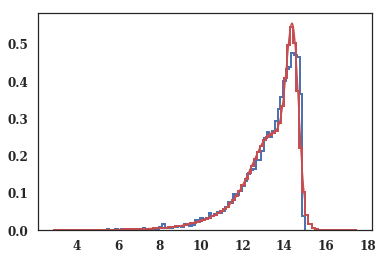

In [101]:
x = np.linspace(4, 15, 1000)
y = marginal_dist(x, params, 'x')
_=plt.plot(x, y/marginal_cdf(x, params, 'x')[-1], c='r')

_=plt.hist(X[:,0], bins=80, normed='density', histtype='step', linewidth=2)
_=plt.hist(Y[0][:,0], bins=100, normed='density', histtype='step', linewidth=2, color='r')

foo_cdf = lambda x: marginal_cdf(x, params, 'x', normed=True)
scipy.stats.kstest(X[:,0], foo_cdf)

In [48]:
gmm

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=20.0, init_params='kmeans',
            max_iter=1000, mean_precision_prior=0.1, mean_prior=None,
            n_components=10, n_init=3, random_state=None, reg_covar=1e-06,
            tol=1e-10, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_process')

In [52]:
gmm.__dict__

{'converged_': False,
 'covariance_prior': None,
 'covariance_prior_': array([[2.02090535, 0.08369374],
        [0.08369374, 0.03510076]]),
 'covariance_type': 'full',
 'covariances_': array([[[ 5.76405490e-01,  3.14337873e-02],
         [ 3.14337873e-02,  1.22865546e-02]],
 
        [[ 7.84099911e-02, -5.10024140e-04],
         [-5.10024140e-04,  6.15463784e-03]],
 
        [[ 5.57469069e-01,  4.35953246e-04],
         [ 4.35953246e-04,  3.10329408e-04]],
 
        [[ 1.37774063e+00, -3.36798973e-02],
         [-3.36798973e-02,  1.49795274e-02]],
 
        [[ 1.99824439e-01,  6.94779248e-03],
         [ 6.94779248e-03,  3.18028228e-03]],
 
        [[ 1.12793733e-01,  2.80211731e-03],
         [ 2.80211731e-03,  8.05494785e-04]],
 
        [[ 7.27579773e-02, -3.21828776e-05],
         [-3.21828776e-05,  2.54874359e-04]],
 
        [[ 1.08649021e+00,  8.77164330e-03],
         [ 8.77164330e-03,  1.03689799e-03]],
 
        [[ 1.52676085e+00,  8.96247981e-02],
         [ 8.96247981e-02, 

In [60]:
gmm.weight_concentration_[0]/np.sum(gmm.weight_concentration_[0])

array([0.14597833, 0.06934685, 0.17638091, 0.01021384, 0.06785881,
       0.07591286, 0.17548506, 0.13071298, 0.07802616, 0.0700842 ])

In [55]:
gmm.weights_

array([0.14614327, 0.069415  , 0.17652599, 0.01022013, 0.06788636,
       0.07592569, 0.17546625, 0.13064014, 0.07791659, 0.06986058])

In [57]:
X.shape

(7964, 2)

In [61]:
from sklearn.neighbors import KernelDensity

In [62]:
kde = KernelDensity(kernel='gaussian')

In [63]:
kde.fit(X)

KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0)

In [67]:
Y = kde.sample(10000)

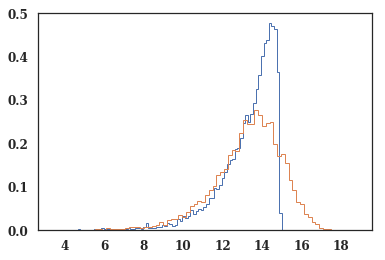

In [70]:
_=plt.hist(X[:,0], bins=80, normed=True, histtype='step')
_=plt.hist(Y[:,0], bins=80, normed=True, histtype='step')

In [84]:
Y = gmm.sample(1000000)

KstestResult(statistic=0.021005509426475943, pvalue=0.001773523598440332)

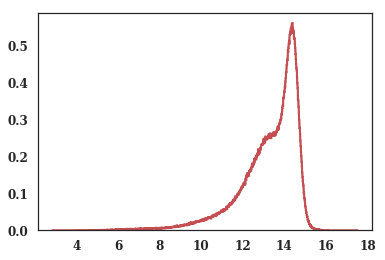

In [100]:
x = np.linspace(4, 15, 1000)
y = marginal_dist(x, params, 'x')
_=plt.plot(x, y/marginal_cdf(x, params, 'x')[-1], c='r')

_=plt.hist(Y[0][:,0], bins=1000, normed='density', histtype='step', linewidth=2, color='r')

foo_cdf = lambda x: marginal_cdf(x, params, 'x', normed=True)
scipy.stats.kstest(X[:,0], foo_cdf)

In [93]:
gmm.covariances_[:,[0,1],[0,1]]

array([[5.76405490e-01, 1.22865546e-02],
       [7.84099911e-02, 6.15463784e-03],
       [5.57469069e-01, 3.10329408e-04],
       [1.37774063e+00, 1.49795274e-02],
       [1.99824439e-01, 3.18028228e-03],
       [1.12793733e-01, 8.05494785e-04],
       [7.27579773e-02, 2.54874359e-04],
       [1.08649021e+00, 1.03689799e-03],
       [1.52676085e+00, 2.72944711e-02],
       [1.60891807e-01, 1.98916692e-03]])

In [95]:
params[:,2:4]

array([[5.76405490e-01, 1.22865546e-02],
       [7.84099911e-02, 6.15463784e-03],
       [5.57469069e-01, 3.10329408e-04],
       [1.37774063e+00, 1.49795274e-02],
       [1.99824439e-01, 3.18028228e-03],
       [1.12793733e-01, 8.05494785e-04],
       [7.27579773e-02, 2.54874359e-04],
       [1.08649021e+00, 1.03689799e-03],
       [1.52676085e+00, 2.72944711e-02],
       [1.60891807e-01, 1.98916692e-03]])

KstestResult(statistic=0.011173131844794626, pvalue=0.2731167631900559)

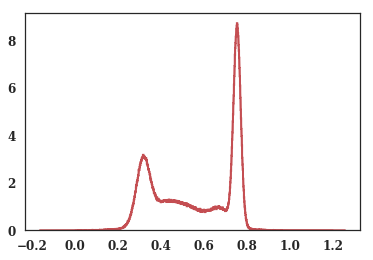

In [99]:
x = np.linspace(0, 1.2, 1000)
y = marginal_dist(x, params, 'y')
_=plt.plot(x, y/marginal_cdf(x, params, 'y')[-1], c='r')

_=plt.hist(Y[0][:,1], bins=1000, normed='density', histtype='step', linewidth=2, color='r')

foo_cdf = lambda x: marginal_cdf(x, params, 'y', normed=True)
scipy.stats.kstest(X[:,1], foo_cdf)

# Test result

In [97]:
def marginal_dist(x, params, axis):
    if axis=='x':
        mu = params[:,0]
        cov = params[:,2]
    elif axis=='y':
        mu = params[:,1]
        cov = params[:,3]
        
    exponent = -0.5*(x[:,np.newaxis]-mu[np.newaxis,:])**2 / (cov[np.newaxis,:])
    norm = 1/np.sqrt(2*np.pi*cov)[np.newaxis,:]
        
    return np.sum(params[:,5][np.newaxis,:]*norm*np.exp(exponent), axis=1)

def marginal_cdf(x, params, axis, normed=False):
    if axis=='x':
        mu = params[:,0]
        cov = params[:,2]
    elif axis=='y':
        mu = params[:,1]
        cov = params[:,3]
        
    components =  0.5*(scipy.special.erf((x[:,np.newaxis] - mu[np.newaxis,:])/(np.sqrt(2*cov[np.newaxis,:]))) + 1)
        
    if normed:
        return np.sum(params[:,5][np.newaxis,:]*components, axis=1)/np.sum(params[:,5])
    return np.sum(params[:,5][np.newaxis,:]*components, axis=1)

def normed_marginal_cdf(x, params, axis):
    if axis=='x':
        mu = params[:,0]
        cov = params[:,2]
    elif axis=='y':
        mu = params[:,1]
        cov = params[:,3]
        
    components =  0.5*(scipy.special.erf((x - mu)/(np.sqrt(2*cov))) + 1)
        
    return np.sum(params[:,5]*components)/np.sum(params[:,5])

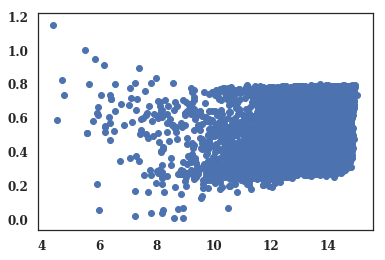

In [18]:
plt.scatter(X[:,0], X[:,1])

KstestResult(statistic=0.04947346768295957, pvalue=2.342780839079132e-17)

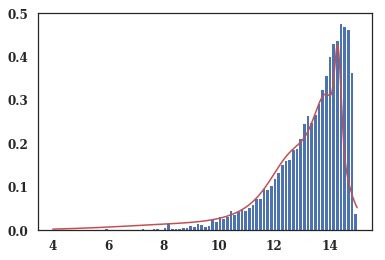

In [28]:
x = np.linspace(4, 15, 1000)
y = marginal_dist(x, params, 'x')
_=plt.plot(x, y/marginal_cdf(x, params, 'x')[-1], c='r')

_=plt.hist(X[:,0], bins=80, normed=True)

foo_cdf = lambda x: marginal_cdf(x, params, 'x', normed=True)
scipy.stats.kstest(X[:,0], foo_cdf)

KstestResult(statistic=0.02102303768328917, pvalue=0.0017528347738093727)

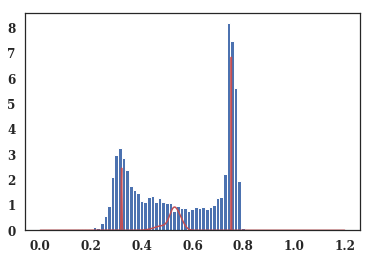

In [31]:
x = np.linspace(0., 1.2, 1000)
y = marginal_dist(x, params, 'y')
_=plt.plot(x, y/marginal_cdf(x, params, 'y')[-1], c='r')

_=plt.hist(X[:,1], bins=80, normed=True)

foo_cdf = lambda x: marginal_cdf(x, params, 'y', normed=True)
scipy.stats.kstest(X[:,1], foo_cdf)